In [1]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
import visdom

vis = visdom.Visdom()
vis.close(env="main")

Setting up a new session...


''

### **define value tracker**

In [3]:
def value_tracker(value_plot, value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=value,
             win = value_plot,
             update='append'
             )

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

### **transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))**
**How to Calculate mean and std in Normalize**

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)

Files already downloaded and verified


In [6]:
#최근 버전에서는 train_data 대신 data,
#train_labels 대신 target을 쓰니 주의하시길..

print(trainset.data.shape)

train_data_mean = trainset.data.mean(axis=(0,1,2))#높이, 너비, 채널.
                                                        # 각 축에 대해 계산
                                                        # 즉, 이미지 데이터의 모든 픽셀에 대해 연산을 수행
                                                        # 이미지 각 채널에 대한 mean 계산
train_data_std = trainset.data.std(axis=(0,1,2))

print(train_data_mean)
print(train_data_std)

train_data_mean = train_data_mean / 255 # 이미지 데이터의 평균과 표준편차를 [0, 1] 범위로 정규화하는 과정
train_data_std = train_data_std / 255 # 이미지 픽셀 값은 [0, 255]

print(train_data_mean)
print(train_data_std)

(50000, 32, 32, 3)
[125.30691805 122.95039414 113.86538318]
[62.99321928 62.08870764 66.70489964]
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [17]:
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4), #(width, height)의 잘라낼 크기를 설정하면, 그 크기만큼 랜덤으로 잘라낸다.
                                          #crop의 크기가 이미지의 크기보다 크면 에러가 난다.
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)
])

trainset = torchvision.datasets.CIFAR10(root='./', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./', train=False,
                                       download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### **make ResNet50 using resnet.py**

In [8]:
import torchvision.models.resnet as resnet

In [9]:
conv1x1 = resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock = resnet.BasicBlock

In [19]:
class ResNet(nn.Module):
    #input size 3 x 32 x 32
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode = 'fan_out', nonlinearity='relu')#가중치 초기화에
                                                                                        #사용되는 정규분포의
                                                                                        #표준편차가 fan_out 값에 따라
                                                                                        #조정
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias, 0)

            if zero_init_residual:
                for m in self.modules():
                    if isinstance(m, Bottleneck):
                        nn.init.constant_(m.bn3.weight, 0)
                    elif isinstance(m, BasicBlock):
                        nn.init.constant_(m.bn2.weight, 0)
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        #x.shape = [batch, 3 ,32, 32]
        x = self.conv1(x)
        #x.shape =[1, 16, 32,32]
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x) #사이즈가 작아서 할 필요가 없다

        x = self.layer1(x)
        #x.shape =[1, 128, 32,32]
        x = self.layer2(x)
        #x.shape =[1, 256, 32,32]
        x = self.layer3(x)
        #x.shape =[1, 512, 16,16]
        x = self.layer4(x)
        #x.shape =[1, 1024, 8,8]
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [11]:
resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], 10, True).to(device)
#1(conv1) + 9(layer1) + 12(layer2) + 18(layer3) + 9(layer4) +1(fc)= ResNet50

In [12]:
resnet50

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [20]:
#뭔가 잘못됐다...
#그래도 돌려본다ㅏㅏㅏ
a=torch.Tensor(1, 3, 32, 32).to(device)
out = resnet50(a)
print(out)

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward>)


In [14]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(resnet50.parameters(), lr = 0.1, momentum = 0.9, weight_decay=5e-4)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

### **make plot**

In [15]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))
acc_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='Accuracy', legend=['Acc'], showlegend=True))

### **define acc_check function**

In [25]:
def acc_check(net, test_set, epoch, save=1):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images) #net: 신경망(Network)을 나타내는 객체
                                  #images를 입력으로 받아 모델의 출력을 계산한다는 뜻
            
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        acc = (100*correct / total)
        print('Accuracy of the network on the 10000 test images: %d %%' % acc)
        if save:
            #net.state_dict(): torch.nn.Module에서 모델로 학습 시,
            #각 층마다 텐서로 매핑되는 매개변수들을 python didctionary타입으로 저장한 객체
            torch.save(net.state_dict(), "./model/model_epoch_{}_acc_{}.pth".format(epoch, int(acc)))
        return acc #model의 parameter만 저장. .pth는 모델의 파일 확장자.

### **Training with (acc check + model save)**

In [27]:
#VGG보다 정확성이 높다!
print(len(trainloader))
epochs = 35

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i%30 == 29:
            value_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
    lr_sche.step()
    acc = acc_check(resnet50, testloader, epoch, save=0) #자꾸 해당 파일이 없습니다. 떠서 save 0으로 해 놨다..
    value_tracker(acc_plt, torch.Tensor([acc]), torch.Tensor([epoch]))
    
print('Finished Training')

196
[1,    30] loss: 1.089
[1,    60] loss: 1.085
[1,    90] loss: 1.053
[1,   120] loss: 1.014
[1,   150] loss: 1.023
[1,   180] loss: 0.976
Accuracy of the network on the 10000 test images: 63 %
[2,    30] loss: 0.898
[2,    60] loss: 0.903
[2,    90] loss: 0.894
[2,   120] loss: 0.879
[2,   150] loss: 0.852
[2,   180] loss: 0.861
Accuracy of the network on the 10000 test images: 68 %
[3,    30] loss: 0.768
[3,    60] loss: 0.778
[3,    90] loss: 0.781
[3,   120] loss: 0.775
[3,   150] loss: 0.772
[3,   180] loss: 0.769
Accuracy of the network on the 10000 test images: 72 %
[4,    30] loss: 0.690
[4,    60] loss: 0.695
[4,    90] loss: 0.650
[4,   120] loss: 0.655
[4,   150] loss: 0.670
[4,   180] loss: 0.657
Accuracy of the network on the 10000 test images: 75 %
[5,    30] loss: 0.606
[5,    60] loss: 0.614
[5,    90] loss: 0.600
[5,   120] loss: 0.584
[5,   150] loss: 0.587
[5,   180] loss: 0.594
Accuracy of the network on the 10000 test images: 78 %
[6,    30] loss: 0.527
[6,    6

### **Model Accuracy Testing**

In [28]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet50(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 86 %


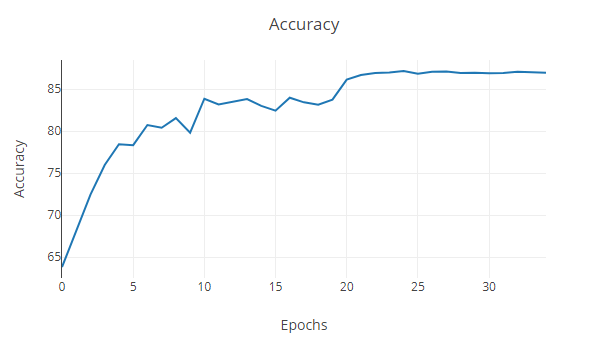

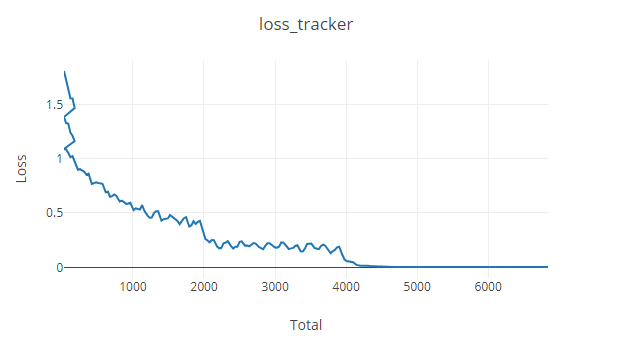